# PDE-FIND for the Kuramoto Sivashinsky Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the Kuramoto Sivashinsky equation.
$$
u_t + u_{xxxx} + uu_x + u_{xx} = 0
$$

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio
from scipy.integrate import odeint
from numpy.fft import fft,ifft,fftfreq

Populating the interactive namespace from numpy and matplotlib


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(pde)? (PDE_FIND.py, line 396)

In [2]:
data = sio.loadmat('./canonicalPDEs/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]

n = len(x)
m = len(t)

Text(0.5,0,'t')

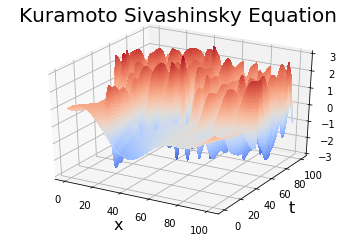

In [3]:
X, T = np.meshgrid(x, t)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Kuramoto Sivashinsky Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=5, P=5, time_diff = 'FD', space_diff = 'FD')

In [5]:
['1']+rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u^5',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u^4u_{x}',
 'u^5u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u^4u_{xx}',
 'u^5u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'u^4u_{xxx}',
 'u^5u_{xxx}',
 'u_{xxxx}',
 'uu_{xxxx}',
 'u^2u_{xxxx}',
 'u^3u_{xxxx}',
 'u^4u_{xxxx}',
 'u^5u_{xxxx}',
 'u_{xxxxx}',
 'uu_{xxxxx}',
 'u^2u_{xxxxx}',
 'u^3u_{xxxxx}',
 'u^4u_{xxxxx}',
 'u^5u_{xxxxx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [6]:
w = TrainSTRidge(R,Ut,10**-5,5)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

PDE_FIND.py:432: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
PDE_FIND.py:635: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
PDE_FIND.py:661: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicit

PDE derived using STRidge
u_t = (-0.984425 +0.000000i)uu_{x}
    + (-0.994175 +0.000000i)u_{xx}
    + (-0.998730 +0.000000i)u_{xxxx}
   


In [7]:
err = abs(np.array([(1-0.984425)*100/0.5, (1-0.994175)*100, (1-0.998730)*100]))
print mean(err)
print std(err)

1.2748333333333324
1.3144149733711288


In [12]:
def TrainSTRidge_2(A, b, num_tols = 50, lam = 1e-5, normalize = 2, STR_iters = 10, l0_penalty = None, split = 0.8):
    """
    Searches over values of tol to find optimal performance.
    Solves Ax=b with sparse x
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    N,D = A.shape
    train = np.random.choice(N, int(N*split), replace = False)
    test = [i for i in np.arange(N) if i not in train]
    A_train = A[train,:]
    A_test = A[test,:]
    b_train = b[train,:]
    b_test = b[test,:]

    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(A_train)

    # First normalize data
    if normalize != 0:

        A_norm = np.zeros_like(A_train)
        Mreg = np.zeros((D,1))

        for i in range(0,D):
            Mreg[i] = 1/(np.linalg.norm(A_train[:,i],normalize))
            A_norm[:,i] = A_train[:,i]*Mreg[i]

    else: A_norm = A_train
    
    # Get array of tols to check
    x_ridge = Ridge(A_norm,b_train,lam)
    max_tol = np.max(abs(x_ridge))
    min_tol = np.min(abs(x_ridge))
    Tol = [0]+[np.exp(alpha) for alpha in np.linspace(np.log(min_tol), np.log(max_tol), num_tols)][:-1]

    # Test each value of tol to find the best
    X = []
    Losses = []

    for tol in Tol:
        # x = STRidge(A_norm,b_train,tol)
        x = STRidge(A_norm,b_train,lam,STR_iters,tol,normalize=0)

        if normalize!= 0:
            x =  np.multiply(Mreg,x)

        X.append(x)
        Losses.append(np.linalg.norm(b_test - A_test.dot(x), 2)**2 + l0_penalty*np.count_nonzero(x))
            
    return X,Tol,Losses

In [14]:
C,Tol,Losses = TrainSTRidge_2(R,Ut)
c = C[np.argmin(Losses)]
print_pde(c, rhs_des)

u_t = (-0.984053 +0.000000i)uu_{x}
    + (-0.993750 +0.000000i)u_{xx}
    + (-0.998328 +0.000000i)u_{xxxx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [15]:
numpy.random.seed(0)
un = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [16]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, width_x = 100, width_t = 30, deg_x = 30, deg_t = 20)
w = TrainSTRidge(Rn,Utn,10**-3,5)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.737445 +0.000000i)uu_{x}
    + (-0.020316 +0.000000i)u^3u_{x}
    + (-0.744215 +0.000000i)u_{xx}
    + (-0.003748 +0.000000i)u^2u_{xx}
    + (0.005816 +0.000000i)u^4u_{xx}
    + (-0.773475 +0.000000i)u_{xxxx}
    + (0.006330 +0.000000i)u^2u_{xxxx}
    + (0.005060 +0.000000i)u^3u_{xxxxx}
   


In [17]:
C,Tol,Losses = TrainSTRidge_2(Rn,Utn)
c = C[np.argmin(Losses)]
print_pde(c, rhs_des)

u_t = (0.003608 +0.000000i)u^5
    + (-0.719567 +0.000000i)uu_{x}
    + (-0.058793 +0.000000i)u^3u_{x}
    + (0.007730 +0.000000i)u^5u_{x}
    + (-0.724394 +0.000000i)u_{xx}
    + (-0.043860 +0.000000i)u^2u_{xx}
    + (0.022516 +0.000000i)u^4u_{xx}
    + (-0.754884 +0.000000i)u_{xxxx}
    + (-0.030778 +0.000000i)u^2u_{xxxx}
    + (0.009744 +0.000000i)u^4u_{xxxx}
    + (0.006409 +0.000000i)u^3u_{xxxxx}
   


In [18]:
C,Tol,Losses = TrainSTRidge_2(Rn,Utn,lam=10**-3)
c = C[np.argmin(Losses)]
print_pde(c, rhs_des)

u_t = (-0.737711 +0.000000i)uu_{x}
    + (-0.020268 +0.000000i)u^3u_{x}
    + (-0.744902 +0.000000i)u_{xx}
    + (-0.003480 +0.000000i)u^2u_{xx}
    + (0.005751 +0.000000i)u^4u_{xx}
    + (-0.773327 +0.000000i)u_{xxxx}
    + (0.006169 +0.000000i)u^2u_{xxxx}
    + (0.005046 +0.000000i)u^3u_{xxxxx}
   


In [21]:
print_pde(C[35], rhs_des)

u_t = (-0.748961 +0.000000i)uu_{x}
    + (-0.744137 +0.000000i)u_{xx}
    + (-0.743635 +0.000000i)u_{xxxx}
   


In [ ]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, width_x = 100, width_t = 30, deg_x = 20, deg_t = 10)
w = TrainSTRidge(Rn,Utn,10**-3,5)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

In [ ]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, width_x = 100, width_t = 30, deg_x = 30, deg_t = 50)
w = TrainSTRidge(Rn,Utn,10**-3,5)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

In [ ]:
C,Tol,Losses = TrainSTRidge_2(Rn,Utn,lam=10**-3)
c = C[np.argmin(Losses)]
print_pde(c, rhs_des)

In [ ]:
err = abs(np.array([(1-0.458521)*100, (1-0.480667)*100, (1-0.492282)*100]))
print mean(err)
print std(err)

## Try Integrating Learned PDE

In [ ]:
def ks_rhs(u, t, params):
    n, k, a, b, c = params
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

k = 2*np.pi*fftfreq(n, d = dx)

# Coefficients learned from clean data
a = -0.984425     # uu_x
b = -0.994175     # u_{xx}
c = -0.998730     # u_{xxxx}

# Coefficients learned from noisy data
an = -0.504533     # uu_x
bn = -0.530002     # u_{xx}
cn = -0.540312     # u_{xxxx}

params = (n, k, a, b, c)
params_n = (n, k, an, bn, cn)

u0 = u[:,0]
u2 = odeint(ks_rhs, u0, t, args=(params,))
u2n = odeint(ks_rhs, u0, t, args=(params_n,))

In [ ]:
X, T = np.meshgrid(x, t)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u2, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Identified Dynamics: Clean Data', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

In [ ]:
X, T = np.meshgrid(x, t)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u2n, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Identified Dynamics: Noisy Data', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)